In [ ]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

In [ ]:
#SK 하이닉스
df = fdr.DataReader('000660', '2023-01-01', '2023-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close   Volume    Change
Date                                                         
2023-01-02   75100   76700   75000   75700  1376985  0.009333
2023-01-03   75600   76300   73100   75600  2719437 -0.001321
2023-01-04   75400   81900   75200   81000  5154609  0.071429
2023-01-05   83300   83300   80800   81400  3510964  0.004938
2023-01-06   81400   83600   81100   83100  3687430  0.020885
...            ...     ...     ...     ...      ...       ...
2023-12-21  139200  140600  138100  140500  2737124  0.000000
2023-12-22  142700  143700  140600  140600  3183709  0.000712
2023-12-26  142000  142000  139400  140900  2239789  0.002134
2023-12-27  140800  141600  139200  140400  2336777 -0.003549
2023-12-28  140900  141600  139500  141500  2459473  0.007835

[245 rows x 6 columns]>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

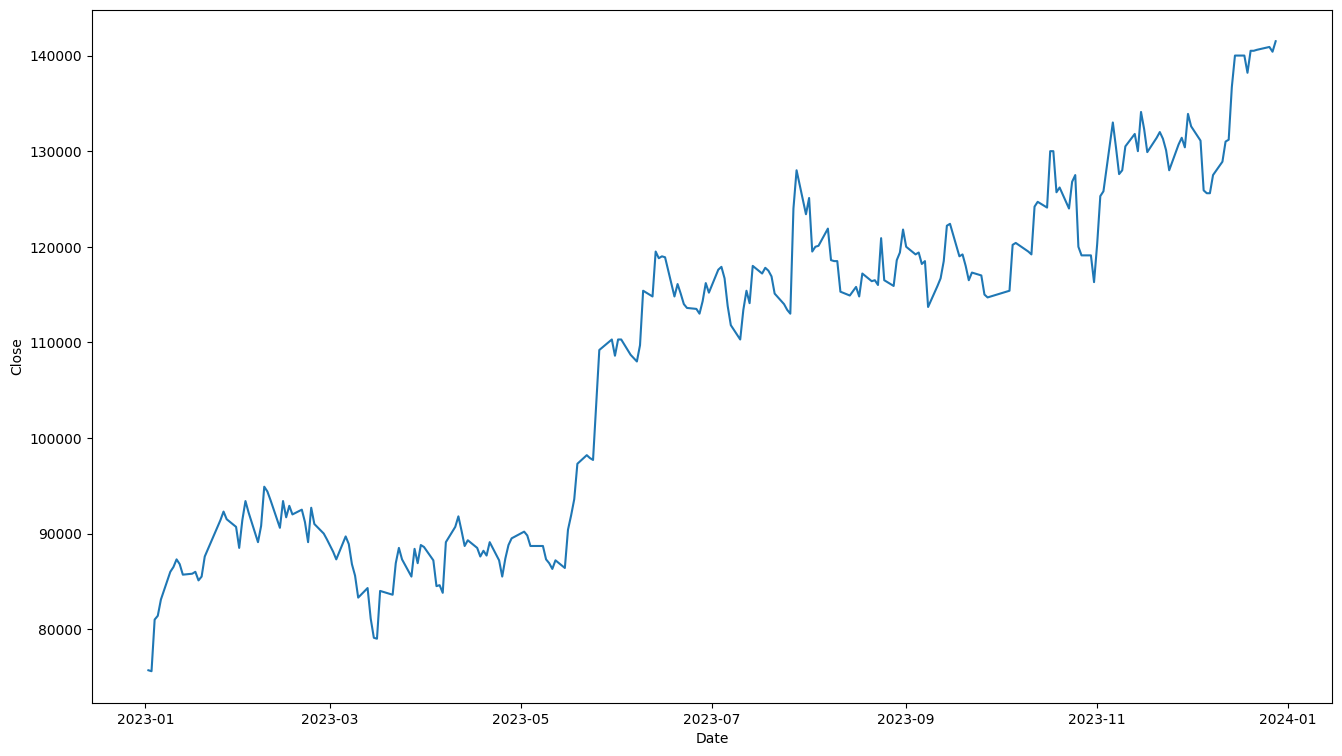

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

In [ ]:
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [ ]:
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values


def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1) #사실 여기서 Model로 안 보내고 training loop 짤 때 device로 보내면 조금 더 범용성 있는 코드...?

In [ ]:
split = 70
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([70, 5, 4]) torch.Size([70, 1])
torch.Size([170, 5, 4]) torch.Size([170, 1])


<ipython-input-12-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


In [ ]:
x_train_seq

tensor([[[0.0000, 0.0059, 0.0281, 0.0000],
         [0.0074, 0.0000, 0.0000, 0.0870],
         [0.0044, 0.0831, 0.0311, 0.2448],
         [0.1213, 0.1039, 0.1141, 0.1383],
         [0.0932, 0.1083, 0.1185, 0.1497]],

        [[0.0074, 0.0000, 0.0000, 0.0870],
         [0.0044, 0.0831, 0.0311, 0.2448],
         [0.1213, 0.1039, 0.1141, 0.1383],
         [0.0932, 0.1083, 0.1185, 0.1497],
         [0.1450, 0.1439, 0.1541, 0.1667]],

        [[0.0044, 0.0831, 0.0311, 0.2448],
         [0.1213, 0.1039, 0.1141, 0.1383],
         [0.0932, 0.1083, 0.1185, 0.1497],
         [0.1450, 0.1439, 0.1541, 0.1667],
         [0.1538, 0.1617, 0.1763, 0.1120]],

        ...,

        [[0.2012, 0.2404, 0.2281, 0.2599],
         [0.2308, 0.2359, 0.2489, 0.2349],
         [0.2485, 0.2329, 0.2459, 0.2187],
         [0.2130, 0.2077, 0.2237, 0.2288],
         [0.2219, 0.2077, 0.2296, 0.0614]],

        [[0.2308, 0.2359, 0.2489, 0.2349],
         [0.2485, 0.2329, 0.2459, 0.2187],
         [0.2130, 0.2077, 0.2237

In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq) #Specify the list of tensors as Dataset (not quite different with torch.util.Dataset)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN


In [ ]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [ ]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.1122
[epoch : 10] loss: 0.0027
[epoch : 20] loss: 0.0025
[epoch : 30] loss: 0.0024
[epoch : 40] loss: 0.0022


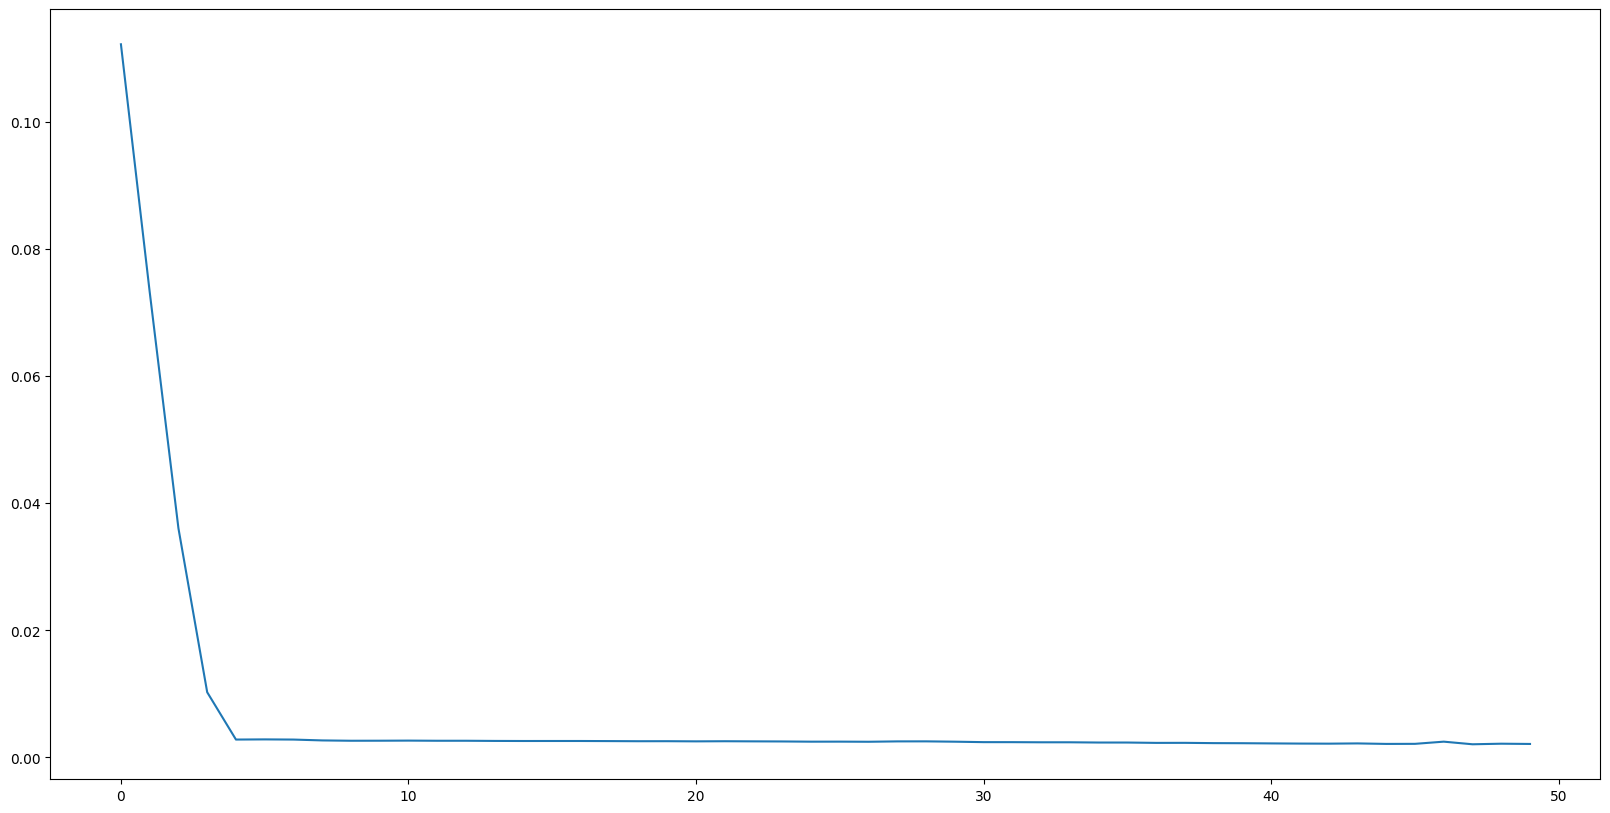

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [ ]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

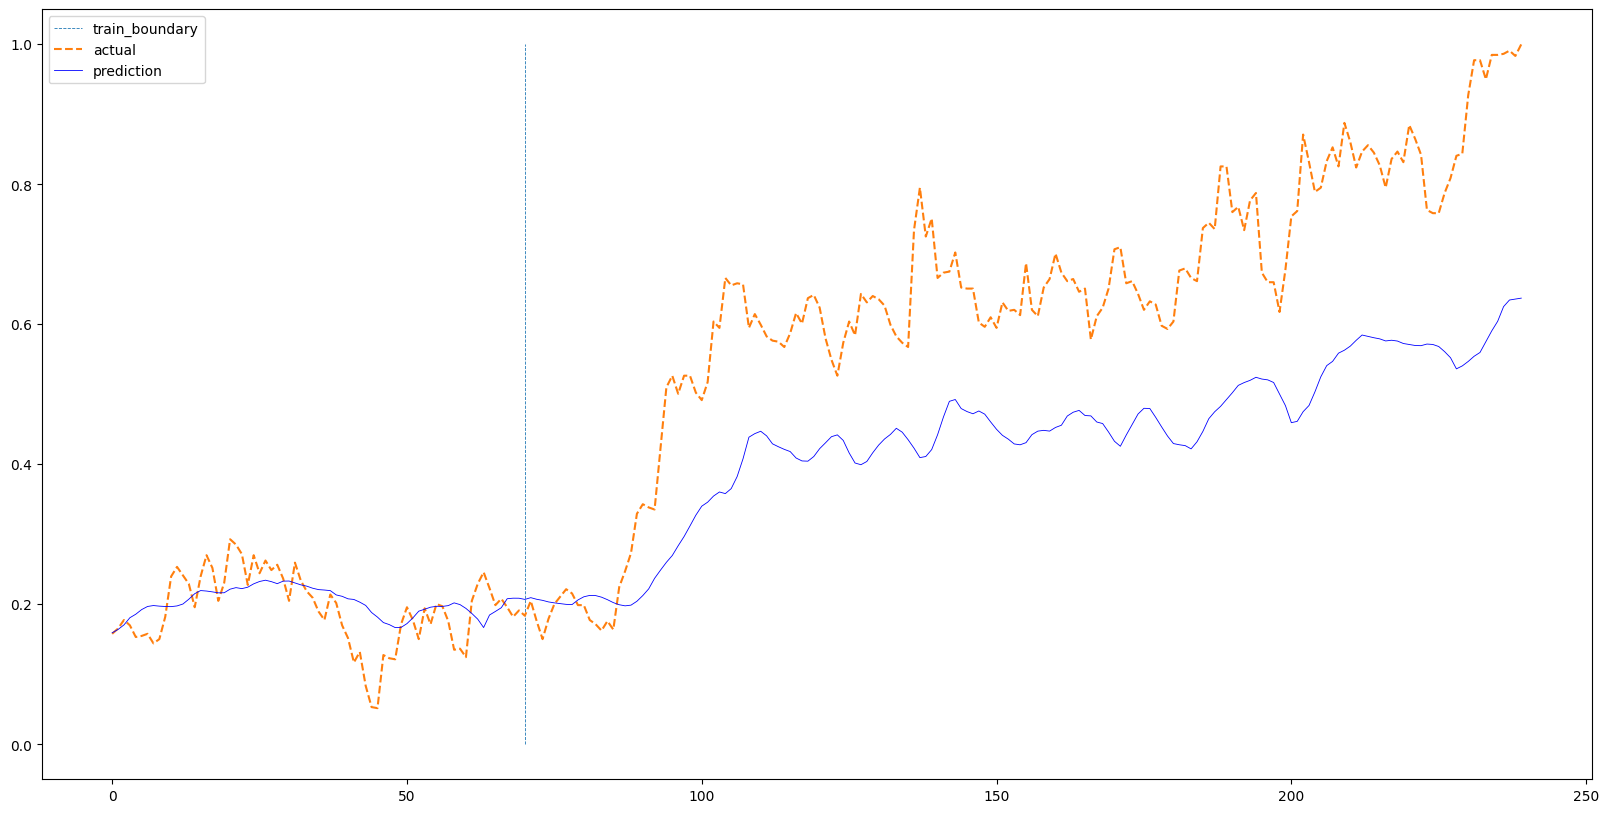

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6) # 예측 종가
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM

In [ ]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [ ]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0030
[epoch: 10] loss: 0.0028
[epoch: 20] loss: 0.0026
[epoch: 30] loss: 0.0022
[epoch: 40] loss: 0.0017


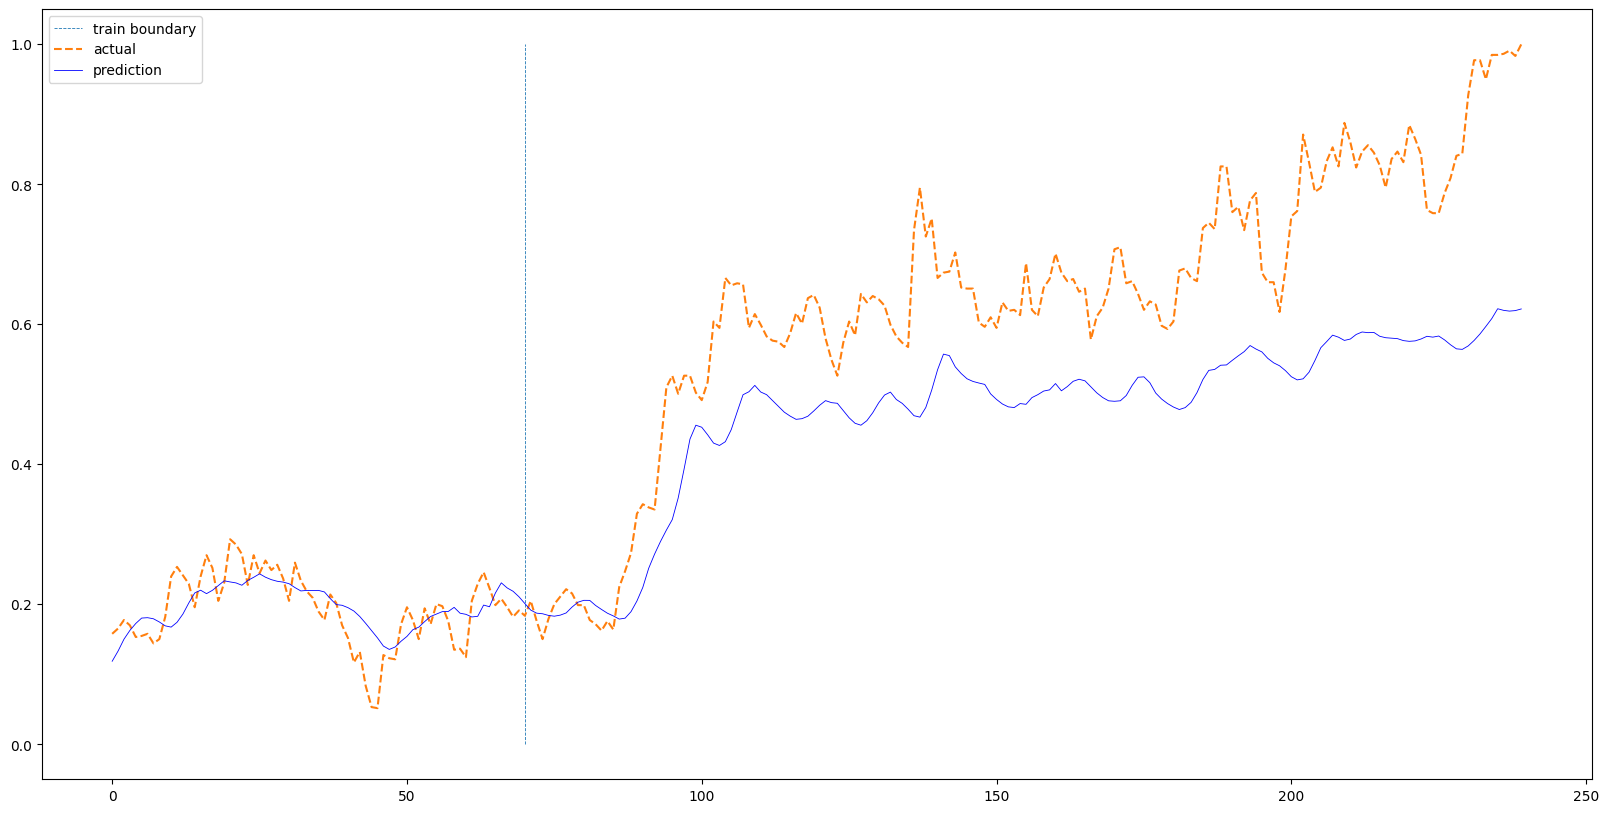

In [ ]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()